In [1]:
%run preprocessing.ipynb
%run evaluation.ipynb

In [3]:
import pandas as pd
import io
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sn
import numpy as np

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 13536)            1         
 torization)                                                     
                                                                 
 reshape (Reshape)           (None, 1, 13536)          0         
                                                                 
 dropout (Dropout)           (None, 1, 13536)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 128)           6963712   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                        

INFO:tensorflow:Assets written to: model\emotions.tf\assets


INFO:tensorflow:Assets written to: model\emotions.tf\assets


Model saved on disk.
Testing the model...
The result obtained is:

63/63 [==============================] - 2s 10ms/step
[[0.78680203 0.05220884 0.20661157 0.0442623  0.03664921 0.07317073]
 [0.03172589 0.80722892 0.03305785 0.05409836 0.05759162 0.02439024]
 [0.06852792 0.01204819 0.7107438  0.01803279 0.01570681 0.04878049]
 [0.06725888 0.07228916 0.00826446 0.8147541  0.05759162 0.02439024]
 [0.03299492 0.04417671 0.03305785 0.05409836 0.76439791 0.09756098]
 [0.01269036 0.01204819 0.00826446 0.0147541  0.06806283 0.73170732]]

Confusion matrix saved on disk.

63/63 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       695
           1       0.81      0.73      0.77       275
           2       0.71      0.54      0.61       159
           3       0.81      0.86      0.83       581
           4       0.76      0.65      0.70       224
           5       0.73      0.45      0.56        6

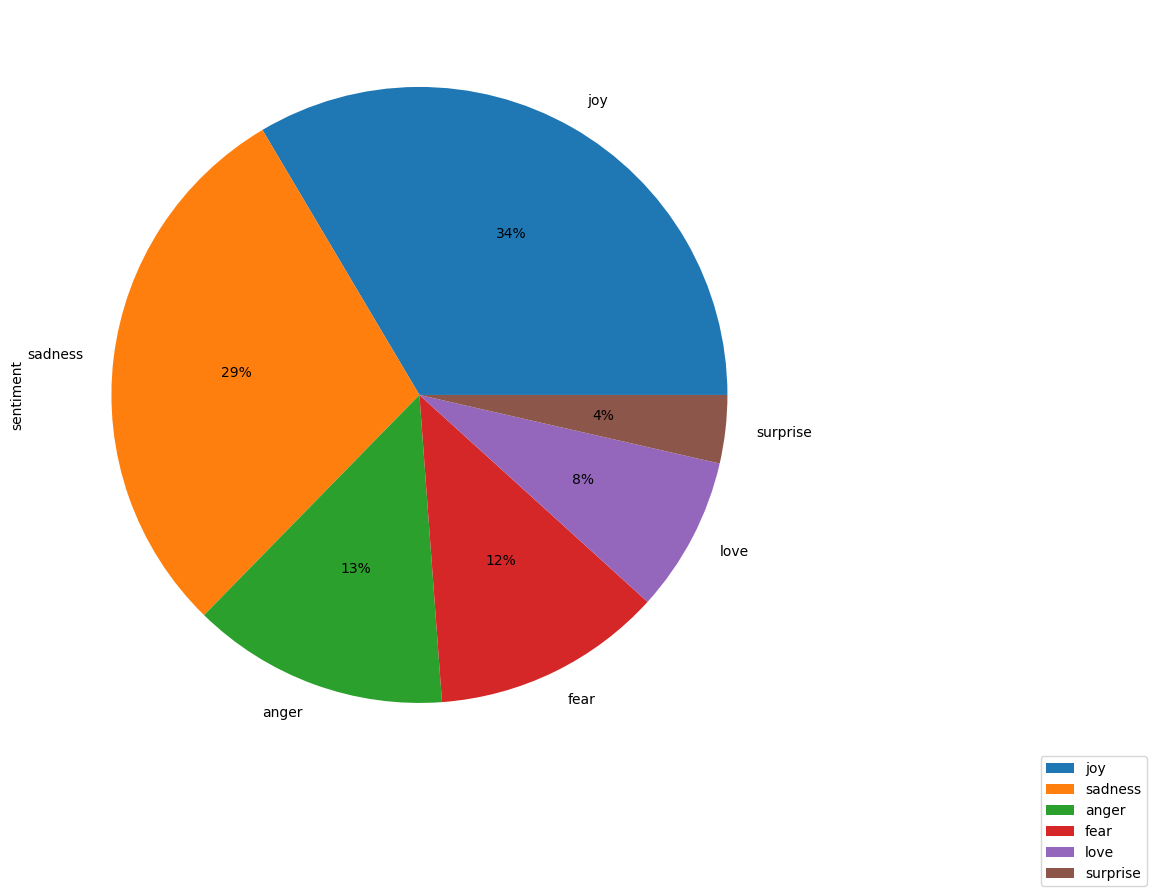

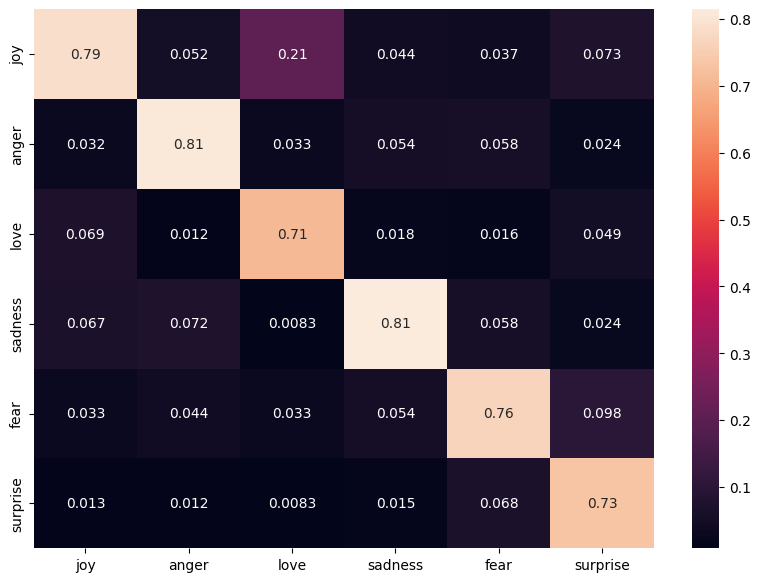

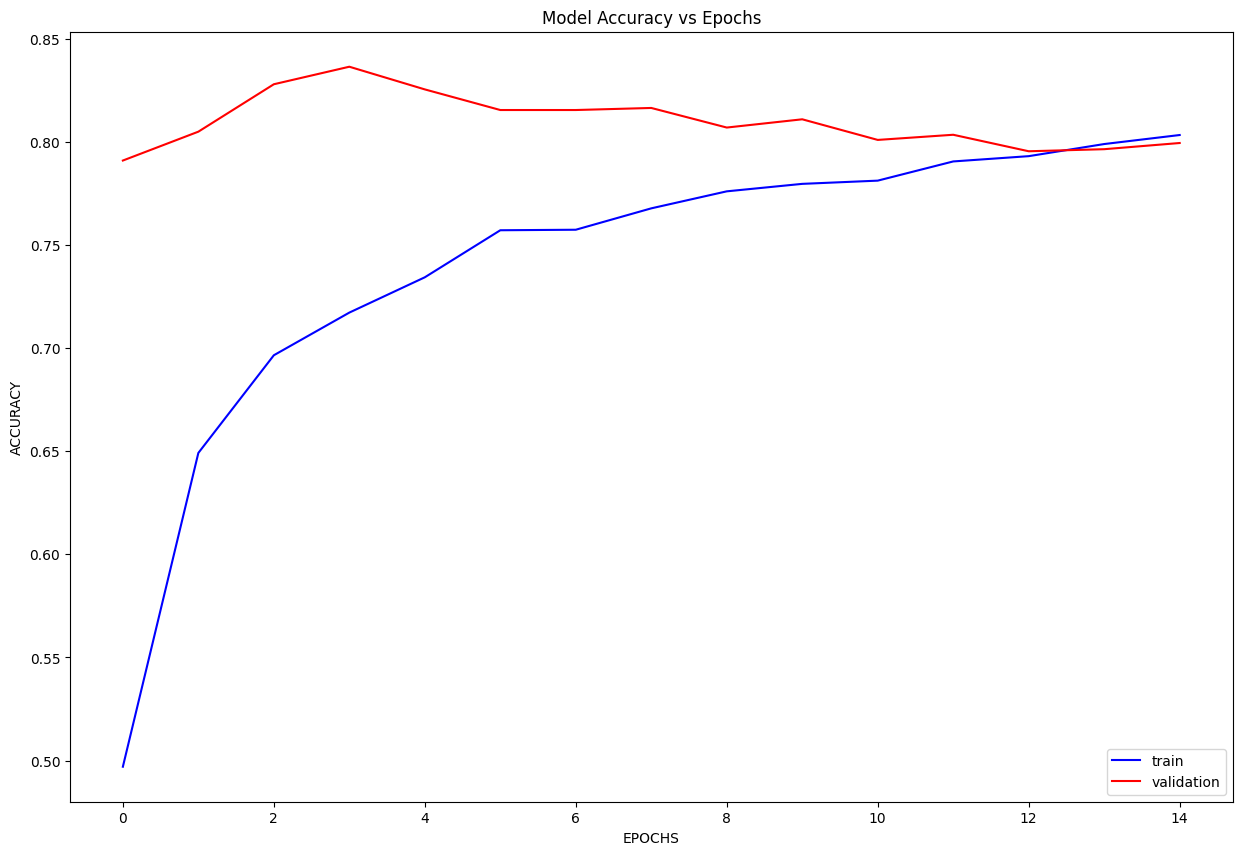

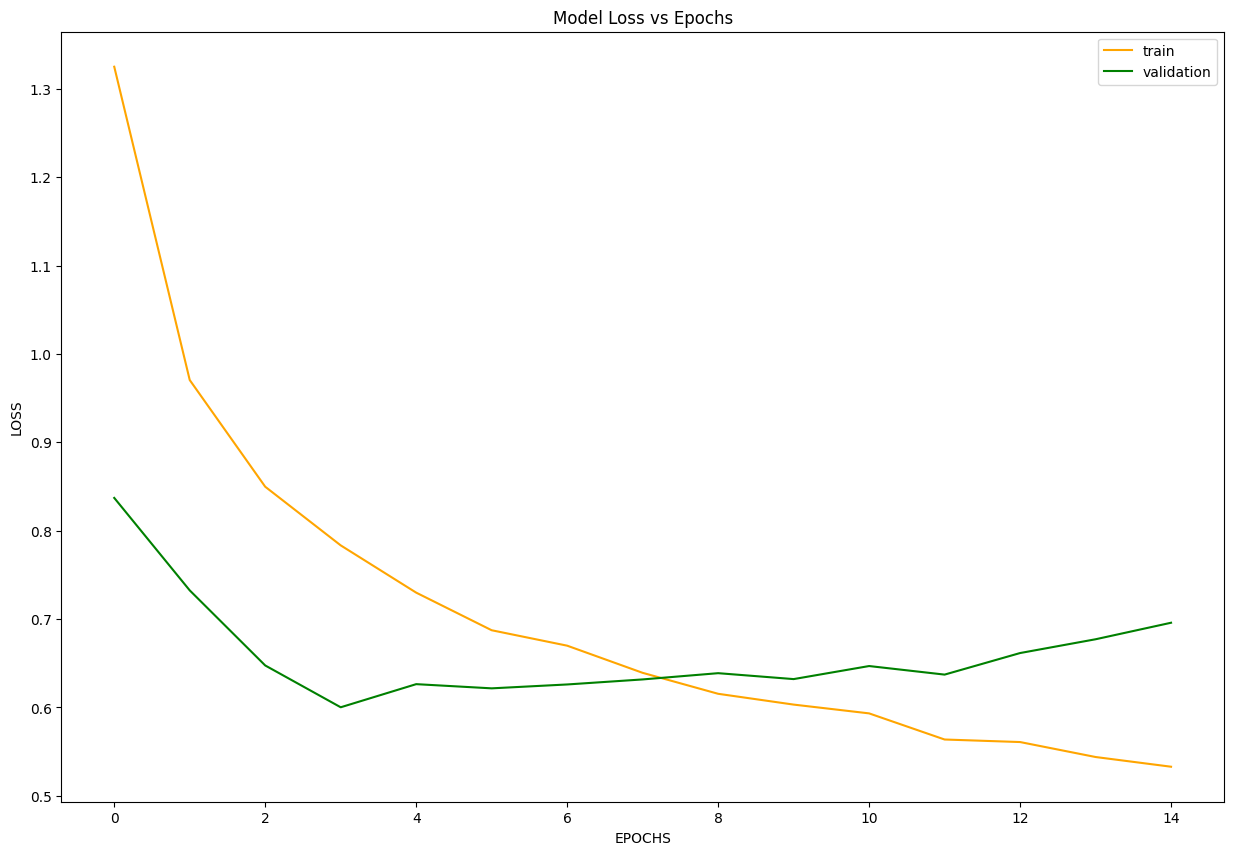

In [5]:
import tensorflow as tf
from keras.layers import TextVectorization

fns = [_removeNumbers, _removeStopWords, _cleanLinks, _cleanAbbreviations, _removeSpecialChars, _removePunctuation, _lemmatization]


# TODO: text vectorization ne radi sa LSTM zbog output dimensions

def trainModel():
    train = pd.read_csv('train.txt', sep=';', names=['text', 'sentiment'])
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    val = pd.read_csv('val.txt', sep=';', names=['text', 'sentiment'])
    _saveClassDistribution(train)

    xtrain, ytrain = preprocess(train, fns)
    xtest, ytest = preprocess(test, fns)
    xval, yval = preprocess(val, fns)

    # WORD EMBEDDING
    MAX_TOKENS_NUM = 15211  # Maximum vocab size.
    MAX_SEQUENCE_LEN = 80  # Sequence length to pad the outputs to.
    EMBEDDING_DIMS = 64

    vectorize_layer = TextVectorization(
    max_tokens=MAX_TOKENS_NUM,
    output_mode='tf-idf',
    #output_sequence_length=MAX_SEQUENCE_LEN
    )
    vectorize_layer.adapt(xtrain)

    model = _makeModel(vectorize_layer)
    hist = model.fit(xtrain, ytrain, epochs=15, validation_data=(xval, yval))
    model.save('model\emotions.tf', save_format='tf')
    print("Model saved on disk.")

    _testModel(model, xtest, ytest)
    _saveFigures(hist)
    plot_model(model=model, to_file='model\model.png', show_layer_names=False, show_shapes=True, show_layer_activations=True)

    return model

def _makeModel(vectorize_layer):
    model = Sequential()

    model.add(tf.keras.Input(shape=(1, ), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(tf.keras.layers.Reshape((1, 13536)))
    # model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    # model.add(Dense(64, activation="relu"))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(6, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

def _testModel(model, xtest, ytest):
    print("Testing the model...")
    print("The result obtained is:\n")
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test, fns)

    model.evaluate(xtest, ytest)


    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    result = confusion_matrix(ytest, yprediction, normalize='pred')
    print(result)

    classes = ["joy", "anger", "love", "sadness", "fear", "surprise"]
    df_cfm = pd.DataFrame(result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sn.heatmap(df_cfm, annot=True)
    cfm_plot.figure.savefig("evaluation\cfm.png")
    print("\nConfusion matrix saved on disk.\n")

    getClassificationReport(model)

def getClassificationReport(model):
    test = pd.read_csv('test.txt', sep=';', names=['text', 'sentiment'])
    xtest, ytest = preprocess(test, fns)
    yprediction = model.predict(xtest)
    yprediction = np.argmax(yprediction, axis=1)
    ytest = np.argmax(ytest, axis=1)
    report = classification_report(ytest, yprediction)
    print(report)
    with io.open('evaluation/classificationreport.txt', 'w', encoding='utf-8') as f:
        f.write(report)

model = trainModel()